# Define canon for SMK paintings

In [261]:
#import requests
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors

## Load smk data

We load the SMK data + metadata in a couple of different formats:

df = Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

metadata = JSON file with *all* metadata from the SMK API, not structured (but indices match pickle file)

ds = HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [262]:
# read df from csv 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_subset.pkl'))

In [263]:
# load metadata json
json_path = os.path.join(data_path, 'all_paintings_metadata')

# Open and read the JSON file
with open(json_path, 'r') as file:
    metadata = json.load(file)

In [264]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [265]:
# add column with greyscale information from ds (i.e., whether the image is greyscale or not)
df['rgb'] = ds['rgb']

#### Add embeddings

In [266]:
# load embeddings
embeddings = np.load(os.path.join(data_path, 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [267]:
# load greyscaled embeddings
grey_embeddings = np.load(os.path.join(data_path, 'GREY_eva02_clip_all_paintings.npy'))
grey_embeddings.shape

(2085, 1024)

In [268]:
# need to convert to list of arrays to add to df
embeddings_list = list(embeddings)
grey_embeddings_list = list(grey_embeddings)
df['embedding'] = embeddings_list
df['grey_embedding'] = grey_embeddings_list

In [269]:
# make sure embeddings are still np arrays and has the correct shape
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)
print(type(df['grey_embedding'].iloc[0]))
print(df['grey_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
(1024,)


In [270]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

In [271]:
df.tail()

smk_id     period  start_year  \
1685  KMS4154       1849        1849   
1686  KMS8817       1817        1817   
1687  KMS8925  1788-1792        1788   
1688  KMS9021  1825-1829        1825   
1689  KMS9034       1868        1868   

                                                title  \
1685             Landskab fra Skiveegnen med Skivehus   
1686                                    Efter stormen   
1687  Portræt af Kennett Dixon, der spiller badminton   
1688                                      Selvportræt   
1689    Portræt af maleren Thorald Læssøe (1816-1878)   

                    first_artist                   all_artists  num_artists  \
1685          Christen Dalsgaard          [Christen Dalsgaard]            1   
1686      Caspar David Friedrich      [Caspar David Friedrich]            1   
1687             William Beechey             [William Beechey]            1   
1688       Emil Ditlev Bærentzen       [Emil Ditlev Bærentzen]            1   
1689  Elisabeth Jerichau Baumann  [Elisabeth Jerichau Baumann]            1   

     main_type all_types                                    image_thumbnail  \
1685    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/6m311t23b_KM...   
1686    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/db78tg36b_KM...   
1687    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/rf55zc238_km...   
1688    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/9880vw79j_km...   
1689    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/sb397d185_km...   

      ...    content_person has_text  \
1685  ...              <NA>     <NA>   
1686  ...              <NA>     <NA>   
1687  ...  [Dixon, Kenneth]     <NA>   
1688  ...              <NA>     <NA>   
1689  ...              <NA>     <NA>   

                                                 colors geo_location  \
1685      [#999999, #888888, #777777, #908d41, #444444]         <NA>   
1686      [#666666, #382510, #230b09, #999999, #888888]         <NA>   
1687  [#222222, #999999, #111111, #777777, #657b42, ...         <NA>   
1688                                               <NA>         <NA>   
1689      [#77733d, #000000, #795025, #080614, #541f0e]         <NA>   

       entropy                                            tags_en  \
1685  9.733417  [field, landscape, nature, grass, tree, outdoo...   
1686  9.783627                   [outdoor, mountain, ship, water]   
1687  9.622585  [human face, clothing, person, drawing, painti...   
1688      <NA>                                               <NA>   
1689   9.73226  [human face, text, clothing, human beard, look...   

                                                  image    rgb  \
1685  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  color   
1686  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  color   
1687  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  color   
1688  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  color   
1689  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  color   

                                              embedding  \
1685  [2.381985902786255, -0.8846017718315125, -0.91...   
1686  [1.9805793762207031, -1.1544833183288574, -0.4...   
1687  [0.7585954666137695, -0.9632124900817871, -0.7...   
1688  [0.4516342878341675, -1.3397136926651, -1.2157...   
1689  [0.47440075874328613, -0.5750328302383423, -1....   

                                         grey_embedding  
1685  [1.597501516342163, -1.6545467376708984, -1.34...  
1686  [2.0533976554870605, -1.2290035486221313, -0.5...  
1687  [0.20546936988830566, -0.4467521905899048, -0....  
1688  [-0.25734424591064453, -1.2444651126861572, -0...  
1689  [-0.19249993562698364, -0.25394660234451294, -...  

[5 rows x 29 columns]

In [272]:
# select metadata based on indices
metadata = [metadata[i] for i in indices]

Besides the metadata we already have in our df, we need to extract some extra data from the metadata json we can use for defining a canon of paintings and add it to our df:

In [273]:
def extract_canon_info(item):

    ''''
    Get information on canon features from smk item
    '''

    content_keys = ['exhibitions',
                    'acquisition_date', 
                    'responsible_department', 
                    'documentation', 
                    'on_display', 
                    'current_location_name',
                    'literary_reference',
                    'object_history_note']

    content_data = {field: item.get(field, pd.NA) for field in content_keys}

    return content_data

In [274]:
data_dicts = []
for item in tqdm(metadata, total=len(metadata)):
    content_data = extract_canon_info(item)
    data_dicts.append(content_data)

data_df = pd.DataFrame(data_dicts)
df = pd.concat([df, data_df], axis=1)     

100%|██████████| 1690/1690 [00:00<00:00, 1385259.68it/s]


In [275]:
df.head(5)

smk_id period  start_year                                  title  \
0  KMS8884   1835        1835               Parti af torvet i Amalfi   
1  KMS4313   1870        1870           Leonora Christina i fængslet   
2  KMS3880   1800        1800       Jurisprudensen. Allegorisk figur   
3  KMS7591   1800        1800                             Filosofien   
4  KMS3769   1844        1844  Udsigt fra Athenatemplet på Akropolis   

         first_artist           all_artists  num_artists main_type all_types  \
0     Martinus Rørbye     [Martinus Rørbye]            1    Maleri  [Maleri]   
1  Kristian Zahrtmann  [Kristian Zahrtmann]            1    Maleri  [Maleri]   
2  Nicolai Abildgaard  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
3  Nicolai Abildgaard  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
4     Martinus Rørbye     [Martinus Rørbye]            1    Maleri  [Maleri]   

                                     image_thumbnail  ...  \
0  https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...  ...   
1  https://iip-thumb.smk.dk/iiif/jp2/7d278w98c_KM...  ...   
2  https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...  ...   
3  https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...  ...   
4  https://iip-thumb.smk.dk/iiif/jp2/w0892f396_KM...  ...   

                                           embedding  \
0  [0.2547459602355957, -0.6865944862365723, 0.94...   
1  [0.7342177629470825, -0.6139540076255798, 0.10...   
2  [0.722366213798523, -0.381448358297348, -0.525...   
3  [0.24958491325378418, -0.5673973560333252, -0....   
4  [-0.5517070889472961, 0.07065780460834503, 0.8...   

                                      grey_embedding  \
0  [-0.4250355362892151, -1.0564152002334595, 0.7...   
1  [0.5037139654159546, -0.522186279296875, -0.02...   
2  [0.2561178207397461, -0.24371886253356934, -0....   
3  [-0.01927855610847473, -0.5728319883346558, -0...   
4  [-1.139587163925171, -0.4562285244464874, 0.76...   

                                         exhibitions      acquisition_date  \
0  [{'exhibition': '"Danish Golden Age" Petit Pal...  2018-11-27T00:00:00Z   
1  [{'exhibition': 'Ære være Leonora', 'date_star...  1941-01-01T00:00:00Z   
2  [{'exhibition': 'Nicolai Abildgaard - Kroppen ...  1930-01-01T00:00:00Z   
3  [{'exhibition': 'Nicolai Abildgaard - Kroppen ...  1991-01-01T00:00:00Z   
4                                               <NA>  1926-01-01T00:00:00Z   

                     responsible_department  \
0  Den Kongelige Maleri- og Skulptursamling   
1  Den Kongelige Maleri- og Skulptursamling   
2  Den Kongelige Maleri- og Skulptursamling   
3  Den Kongelige Maleri- og Skulptursamling   
4  Den Kongelige Maleri- og Skulptursamling   

                                       documentation  on_display  \
0                                               <NA>        True   
1  [{'title': 'Dansk kunst: tusind års kunsthisto...       False   
2  [{'title': 'Fortegnelse over den danske Samlin...       False   
3  [{'title': 'Abildgaard=abildgård: kunstneren m...       False   
4  [{'title': 'Lysets malere: nordisk malerkunst ...        True   

  current_location_name literary_reference  \
0               Sal 219               <NA>   
1                  <NA>               <NA>   
2                  <NA>               <NA>   
3                  <NA>               <NA>   
4               Sal 219               <NA>   

                                 object_history_note  
0                                               <NA>  
1                                               <NA>  
2  [På auktion efter Abildgaards enke solgt til J...  
3                                               <NA>  
4                                               <NA>  

[5 rows x 37 columns]

In [276]:
# get exhibition venues to check how many are from smk
def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        venues = []
        for i in range(len(exhb_dict)):
            venue = exhb_dict[i].get('venue', pd.NA)
            venues.append(venue)
        return venues
    
    else:
        return pd.NA

In [277]:
venues_list = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['exhibition_venues'] = venues_list

If a painting has been in an exhibition at SMK it will be under 'Sølvgade' (the adress for SMK) in 'venues'

In [278]:
def check_smk(venues):
    if isinstance(venues, list):
        if any(isinstance(v, str) and 'Sølvgade' in v for v in venues):
            return True 
        else:
            return False 
    else:
        return False

In [279]:
smk_exhibitions = [check_smk(venues) for venues in df['exhibition_venues']]
df['smk_exhibitions'] = smk_exhibitions

In [280]:
def extract_enrichment_wiki_info(smk_id, session):

    '''
    Make calls to enrichment API and relevant extract information
    '''
    try:
        try:
            # enrichment API can't handle slashes in the smk_id as it sees them as part of the path, so they need to be encoded properly
            encoded_smk_id = urllib.parse.quote(smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()
        
        except Exception:
            # SMK API is case insensitive but Enrichment API is not, so try to make the smk_id uppercase in case this is why the request fails
            uppercase_smk_id = smk_id.upper()
            encoded_smk_id = urllib.parse.quote(uppercase_smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()

        wiki_data = pd.NA
        for item in enrichment_json:
            if item.get('type') == 'wikidata':
                
                wiki_data = item.get('data', pd.NA).get('wikidata_link_da_s', pd.NA)
                
                break

    # if request still fails, print error message and append NA for this object
    except Exception as e:
        #print(f"Error fetching enrichment API data: {enrichment_url}")
        return pd.NA

    return wiki_data

In [281]:
# not sure we need this (and code takes some time to run)
#wiki_data_list = [extract_enrichment_wiki_info(smk_id, session) for smk_id in df['smk_id']]
#df['wiki_data'] = wiki_data_list
#df[~df['wiki_data'].isna()]

Add column with information about whether an exhibition was called something specific with 'gold'

In [282]:
golden = ['gold', 'guld']

def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        titles = []
        for i in range(len(exhb_dict)):
            title = exhb_dict[i].get('exhibition', None)

            if title:
                # Check if any keyword matches (case-insensitive)
                if any(re.search(keyword, title.lower()) for keyword in golden):
                    titles.append(title)

        return titles if titles else pd.NA
    else:
        return pd.NA 

In [283]:
golden_titles = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['golden_titles'] = golden_titles
len(df['golden_titles'].value_counts())

79

In [284]:
# convert columns to 0/1 instead of True/False
df['smk_exhibitions'] = df['smk_exhibitions']*1
df['on_display'] = df['on_display']*1

Create variable on whether the artwork has been exhibited anywhere:

In [285]:
def check_exhibitions(exhibitions):
    if isinstance(exhibitions, list):
        return 1 
    else:
        return 0 

In [286]:
exhibitions = [check_exhibitions(exb) for exb in df['exhibitions']]
df['exb_canon'] = exhibitions

### Check correlations

In [287]:
n_exhibitions_list = []
n_golden_titles_list = []

for idx, row in df.iterrows():    
    n_exhibitions_list.append(len(row['exhibition_venues']) if isinstance(row['exhibition_venues'], list) else pd.NA)
    n_golden_titles_list.append(len(row['golden_titles']) if isinstance(row['golden_titles'], list) else pd.NA)

In [288]:
df['n_exhibitions'] = n_exhibitions_list
df['n_golden_titles'] = n_golden_titles_list 

In [289]:
def n_smk_venues(venues):

    n_venues = 0

    if isinstance(venues, list):
        for v in venues:
            if isinstance(v, str) and v == 'Sølvgade':
                n_venues += 1
            else: 
                n_venues += 0
    else:
        n_venues += 0

    return n_venues

In [290]:
n_smk_exhibitions = [n_smk_venues(venues) for venues in df['exhibition_venues']]
df['n_smk_exhibitions'] = n_smk_exhibitions

In [291]:
no_na_df = df.fillna(0)

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/2020816724.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [292]:
def plot_correlation(target_column, columns):
    fig, ax = plt.subplots(1, 1, figsize = (10,4))
    columns.remove(target_column)

    for i, v in enumerate(columns):
        ax.scatter(no_na_df[target_column], no_na_df[v])
        ax.set_title(f'Correlation coef: {round(no_na_df[target_column].corr(no_na_df[v]), 3)}')
        ax.set_xlabel(target_column)
        ax.set_ylabel(v)

    fig.show()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/1478878060.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


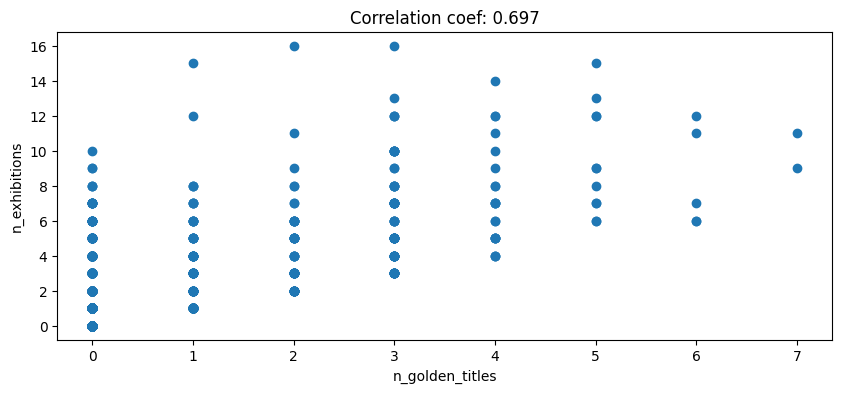

In [293]:
columns = ['n_exhibitions',
 'n_golden_titles']
plot_correlation('n_golden_titles', columns)

In [294]:
# check corr variables

df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)

corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/625316017.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)


In [295]:
# check corr variables

df_corr_nona = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].dropna(how='any')

corr = df_corr_nona.corr()
corr.style.background_gradient(cmap='coolwarm')

In [296]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

### Add column on exhibition years

In [297]:
def get_ex_years(ex_dict_list):
    
    dates = []
    if isinstance(ex_dict_list, list):
        
        for e in ex_dict_list:
            start_date = e.get('date_start', None)

            if start_date:
                start_year = start_date.split('-')[0]
                dates.append(start_year)
            else:
                dates.append(pd.NA)
        
    else:
        dates = pd.NA
    
    return dates

In [298]:
ex_dates = [get_ex_years(ex_dict_list) for ex_dict_list in df['exhibitions']]
df['ex_years'] = ex_dates

#### Add column on exhibition 'distances'

In [299]:
def get_ex_distances(row):

    prod_year = row['start_year']
    diffs = []

    if isinstance(row['ex_years'], list):
        for year in row['ex_years']:
            if isinstance(year, str):
                diff = int(year) - int(prod_year) 
                diffs.append(diff)
            else:
                diffs.append(pd.NA)
    else:
        diffs = pd.NA
    
    return diffs

In [300]:
ex_distances = [get_ex_distances(row) for idx, row in df.iterrows()]
df['ex_distances'] = ex_distances

In [301]:
def get_ex_distances_smk(row):

    if pd.notna(row['acquisition_date']):
        acq_year = row['acquisition_date'].split('-')[0]
        diffs = []

        if isinstance(row['ex_years'], list):
            for idx, year in enumerate(row['ex_years']):
                if isinstance(year, str) and isinstance(row['exhibition_venues'], list):
                    if pd.notna(row['exhibition_venues'][idx]) and row['exhibition_venues'][idx] == 'Sølvgade':
                        diff = int(year) - int(acq_year) 
                        diffs.append(diff)
                    else:
                        diffs.append(pd.NA)
                else:
                    diffs.append(pd.NA)
        else:
            diffs = pd.NA
    else:
        diffs = pd.NA
    return diffs

In [302]:
smk_distances = [get_ex_distances_smk(row) for idx, row in df.iterrows()]
df['smk_distances'] = smk_distances

In [303]:
dist_canon = []
for dists in df['ex_distances']:

    canon = 0
    if isinstance(dists, list):
        big_dists = [i for i in dists if i > 150]

        if len(big_dists) > 0:
            canon =+ 1
        else:
            canon =+ 0
        dist_canon.append(canon)
    else:
        dist_canon.append(0)

In [304]:
df['dist_canon'] = dist_canon

#### Add exhibitions canon

In [305]:
exb_canon = []

for idx, row in df.iterrows():
    exb_years = row['ex_years']

    if isinstance(exb_years, list):
        match = False
        for year in exb_years:
            if year.startswith('2') == True:
                match = True
                break
            
            else:
                continue

        if match == True:
            exb_canon.append('canon')
        
        else:
            exb_canon.append('other')

    else:
        exb_canon.append('other')

df['exb_canon'] = exb_canon

#### Make canon index by copying the formula by M. Tolonen et al. (2021)

In [306]:
no_na_df = df.fillna(0)
total_exb_count = no_na_df['n_exhibitions'].sum()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/2339353792.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [307]:
unique_years = [np.unique(years).tolist() for years in no_na_df['ex_years']]
no_na_df['unique_exb_years'] = unique_years

In [308]:
# calculate canon index based on formula by M. Tolonen et al.
def canon_idx(row, total_exb_count):

    unique_exb_years = len(row['unique_exb_years'])

    idx = unique_exb_years * (row['n_exhibitions'] / total_exb_count)

    return idx

In [309]:
canon_idxes = [canon_idx(row, total_exb_count) for idx, row in no_na_df.iterrows()]
df['canon_idx'] = canon_idxes

In [310]:
def add_mean_prod_year(df):

    mean_years = []

    for idx, row in df.iterrows():
        if '-' in row['period']:
        #row['period'].str.contains('-'):
            start_year = int(row['period'].split('-')[0])
            end_year = int(row['period'].split('-')[-1])
        
            mean_year = (start_year + end_year) // 2
            mean_years.append(mean_year)

        else:
            mean_years.append(row['start_year'])


    df['mean_prod_year'] = mean_years

    return df

In [311]:
df = add_mean_prod_year(df)

In [312]:
# change canon variables from 0 / 1 to other / canon
columns = ['exb_canon', 'dist_canon', 'on_display', 'smk_exhibitions']

for column in columns:
    df[column] = df[column].replace({0: 'other', 1: 'canon'})

In [313]:
df['smk_exhibitions'].value_counts()

smk_exhibitions
other    1320
canon     370
Name: count, dtype: int64

In [317]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'embedding',
       'grey_embedding', 'exhibitions', 'acquisition_date',
       'responsible_department', 'documentation', 'on_display',
       'current_location_name', 'literary_reference', 'object_history_note',
       'exhibition_venues', 'smk_exhibitions', 'golden_titles', 'exb_canon',
       'n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'ex_years',
       'ex_distances', 'smk_distances', 'dist_canon', 'canon_idx',
       'mean_prod_year'],
      dtype='object')

In [318]:
period_subset = df[df['period'].str.contains('-')]

diff_list = []
for idx, row in period_subset.iterrows():
    start_year = int(row['period'].split('-')[0])
    end_year = int(row['period'].split('-')[-1])

    diff = end_year - start_year

    diff_list.append(diff)

period_subset['prod_length'] = diff_list

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/2062557880.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_subset['prod_length'] = diff_list


In [326]:
period_subset.sort_values(by = 'prod_length', ascending=False)

smk_id     period  start_year  \
491      KMS4863  1751-1880        1751   
661      KMS7019  1841-1941        1841   
527      KMS8470  1818-1918        1818   
387   KKSgb13229  1778-1878        1778   
1448     KMSr178  1820-1920        1820   
...          ...        ...         ...   
245      KMS6220  1777-1778        1777   
266       KMS260  1833-1834        1833   
738        KMS42  1822-1823        1822   
320      KMShm10  1857-1858        1857   
386       KMS216  1831-1832        1831   

                                               title  \
491             Prospekt fra Canale Grande i Venezia   
661                                            Maske   
527                                Hus med hønsegård   
387             Olieskitse til Vandringen til Emmaus   
1448                            Nature morte cubiste   
...                                              ...   
245   Udsigt over Lac Léman mod Mont Blanc og Genève   
266                           Skovparti ved Hellebæk   
738                              Slaget ved Sehested   
320        Portræt af maleren Fritz Melbye (1826-69)   
386                  Et skibbrud ved den norske kyst   

                  first_artist                 all_artists  num_artists  \
491                   Ubekendt                  [Ubekendt]            1   
661      Carl-Henning Pedersen     [Carl-Henning Pedersen]            1   
527                Hans Smidth               [Hans Smidth]            1   
387                Anton Dorph               [Anton Dorph]            1   
1448  Louis Casimir Marcoussis  [Louis Casimir Marcoussis]            1   
...                        ...                         ...          ...   
245                  Jens Juel                 [Jens Juel]            1   
266                 Adolf Carl                [Adolf Carl]            1   
738            Jørgen V. Sonne           [Jørgen V. Sonne]            1   
320           Camille Pissarro          [Camille Pissarro]            1   
386                  J.C. Dahl                 [J.C. Dahl]            1   

     main_type          all_types  \
491     Maleri           [Maleri]   
661     Maleri           [Maleri]   
527     Maleri           [Maleri]   
387     Maleri  [Maleri, Tegning]   
1448    Maleri           [Maleri]   
...        ...                ...   
245     Maleri           [Maleri]   
266     Maleri           [Maleri]   
738     Maleri           [Maleri]   
320     Maleri           [Maleri]   
386     Maleri           [Maleri]   

                                        image_thumbnail  ... n_exhibitions  \
491   https://api.smk.dk/api/v1/thumbnail/ba7c7f85-b...  ...          <NA>   
661   https://iip-thumb.smk.dk/iiif/jp2/765374360_KM...  ...             2   
527   https://iip-thumb.smk.dk/iiif/jp2/6969z3888_KM...  ...          <NA>   
387   https://api.smk.dk/api/v1/thumbnail/810374e2-5...  ...          <NA>   
1448  https://api.smk.dk/api/v1/thumbnail/5a3ac17c-8...  ...          <NA>   
...                                                 ...  ...           ...   
245   https://iip-thumb.smk.dk/iiif/jp2/hd76s381p_KM...  ...             1   
266   https://api.smk.dk/api/v1/thumbnail/c5bf3013-5...  ...          <NA>   
738   https://iip-thumb.smk.dk/iiif/jp2/7w62fc07c_KM...  ...          <NA>   
320   https://api.smk.dk/api/v1/thumbnail/a25c32f0-8...  ...             3   
386   https://iip-thumb.smk.dk/iiif/jp2/794081260_KM...  ...             2   

     n_golden_titles n_smk_exhibitions            ex_years     ex_distances  \
491             <NA>                 0                <NA>             <NA>   
661                1                 1        [2005, 2002]       [164, 161]   
527             <NA>                 0                <NA>             <NA>   
387             <NA>                 0                <NA>             <NA>   
1448            <NA>                 0                <NA>             <NA>   
...              ...               ...                 ...     

In [396]:
period_subset.query('prod_length > 40').sort_values(by='prod_length', ascending=False)[['period', 'birth_death']]

period  birth_death
491   1751-1880       [<NA>]
661   1841-1941  [1913-2007]
497   1757-1857  [1812-1857]
527   1818-1918  [1839-1917]
387   1778-1878  [1831-1914]
...         ...          ...
1418  1760-1802  [1745-1802]
1323  1760-1802  [1745-1802]
1416  1760-1802  [1745-1802]
1327  1760-1802  [1745-1802]
1435  1807-1848  [1792-1870]

[256 rows x 2 columns]

In [406]:
df.query('first_artist == "Jens Juel"')

smk_id     period  start_year  \
13     KMS1560  1798-1801        1798   
110    KMS4810       1779        1779   
137   KMSsp868       1787        1787   
138   KMSsp867       1790        1790   
148    KMS2098  1793-1797        1793   
...        ...        ...         ...   
1426   KMS1002       1764        1764   
1428    KMS797       1786        1786   
1433   KMS1824       1782        1782   
1434   KMS1816  1760-1802        1760   
1442   KMS3990  1762-1766        1762   

                                                  title first_artist  \
13                            Gertrud Hage, f. Heitmann    Jens Juel   
110   Baronesse Matilda Guiguer de Prangins i sin pa...    Jens Juel   
137   Et måneskinsstykke. Overfarten over Lillebælt ...    Jens Juel   
138   Den opgående sol i en bjergrig egn, i forgrund...    Jens Juel   
148                Det Rybergske familiebillede. Skitse    Jens Juel   
...                                                 ...          ...   
1426                Postmester Frederik Carl Harboe (?)    Jens Juel   
1428                          Frederik VI som kronprins    Jens Juel   
1433                    Prospekt af egnen om Jægerspris    Jens Juel   
1434        Portrætskitse. Maleren N.A. Abildgaard (?).    Jens Juel   
1442                       Selvportræt ved kunstigt lys    Jens Juel   

      all_artists  num_artists main_type all_types  \
13    [Jens Juel]            1    Maleri  [Maleri]   
110   [Jens Juel]            1    Maleri  [Maleri]   
137   [Jens Juel]            1    Maleri  [Maleri]   
138   [Jens Juel]            1    Maleri  [Maleri]   
148   [Jens Juel]            1    Maleri  [Maleri]   
...           ...          ...       ...       ...   
1426  [Jens Juel]            1    Maleri  [Maleri]   
1428  [Jens Juel]            1    Maleri  [Maleri]   
1433  [Jens Juel]            1    Maleri  [Maleri]   
1434  [Jens Juel]            1    Maleri  [Maleri]   
1442  [Jens Juel]            1    Maleri  [Maleri]   

                                        image_thumbnail  ... n_golden_titles  \
13    https://iip-thumb.smk.dk/iiif/jp2/tb09j948j_km...  ...               1   
110   https://api.smk.dk/api/v1/thumbnail/f8baf5d9-8...  ...            <NA>   
137   https://iip-thumb.smk.dk/iiif/jp2/xp68kk438_km...  ...               2   
138   https://api.smk.dk/api/v1/thumbnail/3c12e90a-a...  ...            <NA>   
148   https://iip-thumb.smk.dk/iiif/jp2/x920g110m_KM...  ...            <NA>   
...                                                 ...  ...             ...   
1426  https://api.smk.dk/api/v1/thumbnail/bfa7147c-7...  ...            <NA>   
1428  https://api.smk.dk/api/v1/thumbnail/50e9d43b-4...  ...            <NA>   
1433  https://iip-thumb.smk.dk/iiif/jp2/ns0648771_KM...  ...            <NA>   
1434  https://iip-thumb.smk.dk/iiif/jp2/cc08hj68s_KM...  ...            <NA>   
1442  https://iip-thumb.smk.dk/iiif/jp2/6682x7277_km...  ...            <NA>   

     n_smk_exhibitions                              ex_years  \
13                   0  [2007, 2005, 1996, 2025, 2025, 2026]   
110                  1  [2003, 2017, 1996, 2025, 2025, 2026]   
137                  1  [2011, 2011, 2005, 2001, 2001, 2024]   
138                  0                                  <NA>   
148                  0                                [2017]   
...                ...                                   ...   
1426                 0                                  <NA>   
1428                 0                                  <NA>   
1433                 0              [2011, 2011, 2009, 2007]   
1434                 0                                  <NA>   
1442                 0                    [2025, 2025, 2026]   

                        ex_distances                         smk_distances  \
13    [209, 207, 198, 227, 227, 228]  [<NA>, <NA>, <NA>, <NA>, <NA>, <NA>]   
110   [224, 238, 217, 246, 246, 247]    [<NA>, 63, <NA>, <NA>, <NA>, <NA>]   
137   [224, 224, 218, 214, 214, 237] 

In [407]:
metadata[1323]['production_dates_notes']

['Værkdatering: 1760-1802',
 'Påbegyndt: baseret på kunstnerens årstal afsluttet: baseret på kunstnerens årstal']

In [411]:
period_indices = period_subset.index.tolist()

In [414]:
period_metadata = [metadata[i] for i in period_indices]

In [416]:
len(period_metadata)

683

In [417]:
len(period_subset)

683

In [ ]:
prod_notes = [period_metadata['production_dates_notes']]

In [ ]:
df['period'].iloc[1687]

'1788-1792'

In [429]:
df['period'].iloc[1687].contains('-')

AttributeError: 'str' object has no attribute 'contains'

In [430]:
#period_subset = df[df['period'].str.contains('-')]

diff_list = []
for idx, row in df.iterrows():

    if '-' in row['period']:
        start_year = int(row['period'].split('-')[0])
        end_year = int(row['period'].split('-')[-1])

        diff = end_year - start_year

        diff_list.append(diff)
    
    else:
        diff_list.append(0)

In [434]:
df['prod_diff'] = diff_list

In [437]:
prod_notes = [dict.get('production_dates_notes', pd.NA) for dict in metadata]

In [438]:
df['prod_notes'] = prod_notes

In [459]:
prod_df = df.query('prod_diff > 30')[['period', 'prod_diff', 'prod_notes', 'birth_death', 'first_artist', 'exb_canon']]

In [460]:
prod_df.to_csv('long_prod_paintings.csv')

In [451]:
df.iloc[661]['prod_notes']

['Værkdatering: Senest 1941',
 'Påbegyndt: baseret på kunstnerens årstal afsluttet: fagligt skøn']

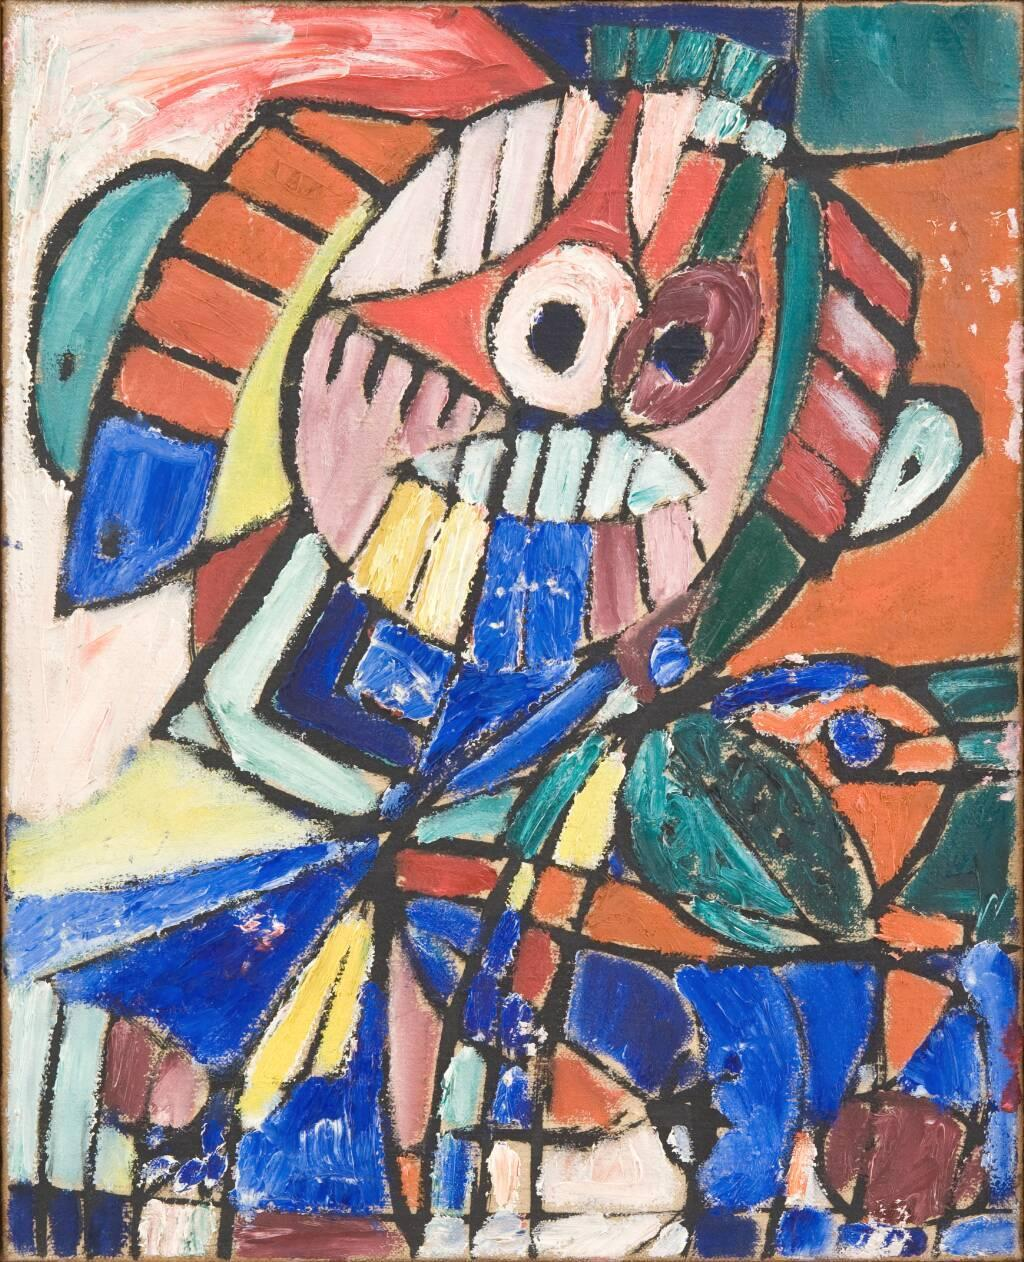

In [450]:
ds[661]['image']

In [424]:
df[['period', 'prod_notes']]

period                                         prod_notes
0          1835                               [Værkdatering: 1835]
1          1870                               [Værkdatering: 1870]
2          1800                               [Værkdatering: 1800]
3          1800                               [Værkdatering: 1800]
4          1844                               [Værkdatering: 1844]
...         ...                                                ...
1685       1849                               [Værkdatering: 1849]
1686       1817  [Værkdatering: 1817, Den angivne datering fore...
1687  1788-1792                           [Værkdatering: Ca. 1790]
1688  1825-1829                           [Værkdatering: Ca. 1827]
1689       1868                             [Værkdatering: (1868)]

[1690 rows x 2 columns]

In [ ]:
prod_notes = [period_metadata[i] for i in period_indices]

[{'id': '1170012517_object',
  'created': '2020-03-21T10:47:36Z',
  'modified': '2025-02-05T08:56:22Z',
  'responsible_department': 'Den Kongelige Maleri- og Skulptursamling',
  'backside_protection': True,
  'acquisition_date': '1898-01-01T00:00:00Z',
  'acquisition_date_precision': '1898-12-31',
  'content_person': ['Hage, Getrud'],
  'content_person_full': [{'name': 'Hage, Getrud',
    'full_name': 'Getrud Hage',
    'forename': 'Getrud',
    'surname': 'Hage',
    'gender': 'UNKNOWN'}],
  'dimensions': [{'notes': '990 x 735 mm',
    'part': 'Netto',
    'type': 'højde',
    'unit': 'centimeter',
    'value': '99'},
   {'notes': '990 x 735 mm',
    'part': 'Netto',
    'type': 'bredde',
    'unit': 'centimeter',
    'value': '73.5'},
   {'notes': '1156 x 895 x 75 mm',
    'part': 'Brutto',
    'type': 'højde',
    'unit': 'centimeter',
    'value': '115.6'},
   {'notes': '1156 x 895 x 75 mm',
    'part': 'Brutto',
    'type': 'bredde',
    'unit': 'centimeter',
    'value': '89.5'},

In [398]:
df['birth_death'].explode()

0       1803-1848
1       1843-1917
2       1743-1809
3       1743-1809
4       1803-1848
          ...    
1685    1824-1907
1686    1774-1840
1687    1753-1839
1688    1799-1868
1689    1819-1881
Name: birth_death, Length: 1698, dtype: object

In [400]:
# check how many follow the birth and death year of artist

period_match = []
for idx, row in df.iterrows():

    birth_death = row['birth_death'][0]
    if isinstance(birth_death, str):
        if row['birth_death'][0] == row['period']:
            period_match.append('yes')
        else:
            period_match.append('no')
    else:
        period_match.append('no')

In [401]:
df['period_match'] = period_match

In [402]:
df['period_match'].value_counts()

period_match
no     1687
yes       3
Name: count, dtype: int64

In [403]:
df.query('period_match == "yes"')

smk_id     period  start_year  \
98      KKSgb13517  1798-1854        1798   
531  KKShm1976-351  1827-1875        1827   
604        KMS1982  1790-1795        1790   

                                                 title  \
98                    Ruiner. Caracallas termer i Rom?   
531  Nattestemning med ildebrande i St-Vast-là-haut...   
604                            Jomfru Maria med Barnet   

               first_artist               all_artists  num_artists main_type  \
98            Ditlev Blunck           [Ditlev Blunck]            1    Maleri   
531  Jean-Baptiste Carpeaux  [Jean-Baptiste Carpeaux]            1    Maleri   
604                Ubekendt                [Ubekendt]            1    Maleri   

             all_types                                    image_thumbnail  \
98   [Maleri, Tegning]  https://api.smk.dk/api/v1/thumbnail/43e51ab2-2...   
531  [Maleri, Tegning]  https://api.smk.dk/api/v1/thumbnail/9cc48385-7...   
604           [Maleri]  https://api.smk.dk/api/v1/thumbnail/cc4fdd34-9...   

     ... n_golden_titles n_smk_exhibitions                  ex_years  \
98   ...               1                 0                    [2017]   
531  ...            <NA>                 0  [2002, 2003, 2003, 2003]   
604  ...            <NA>                 0                      <NA>   

             ex_distances             smk_distances dist_canon  canon_idx  \
98                  [219]                    [<NA>]      canon   0.000429   
531  [175, 176, 176, 176]  [<NA>, <NA>, <NA>, <NA>]      canon   0.003433   
604                  <NA>                      <NA>      other   0.000000   

    mean_prod_year          tester period_match  
98            1826   Olie på papir          yes  
531           1851  Olie på lærred          yes  
604           1792     Olie på pap          yes  

[3 rows x 52 columns]

In [404]:
df['birth_death'].iloc[604]

['1790-1795']

In [387]:
df['birth_death'].explode()

0       1803-1848
1       1843-1917
2       1743-1809
3       1743-1809
4       1803-1848
          ...    
1685    1824-1907
1686    1774-1840
1687    1753-1839
1688    1799-1868
1689    1819-1881
Name: birth_death, Length: 1698, dtype: object

In [389]:
type(df['period'].explode().iloc[1])

str

In [347]:
metadata[527].keys()

dict_keys(['id', 'created', 'modified', 'responsible_department', 'acquisition_date', 'acquisition_date_precision', 'dimensions', 'documentation', 'inscriptions', 'materials', 'object_names', 'production', 'production_date', 'techniques', 'titles', 'number_of_parts', 'object_history_note', 'object_number', 'object_url', 'frontend_url', 'iiif_manifest', 'enrichment_url', 'similar_images_url', 'production_dates_notes', 'public_domain', 'rights', 'on_display', 'alternative_images', 'image_mime_type', 'image_iiif_id', 'image_iiif_info', 'image_width', 'image_height', 'image_size', 'image_thumbnail', 'image_native', 'image_cropped', 'image_orientation', 'image_hq', 'has_3d_file', 'has_image', 'colors', 'suggested_bg_color', 'entropy', 'contrast', 'saturation', 'colortemp', 'brightness', 'has_text', 'artist'])

In [352]:
metadata[527]['production_dates_notes']

['Værkdatering: Før 1918']

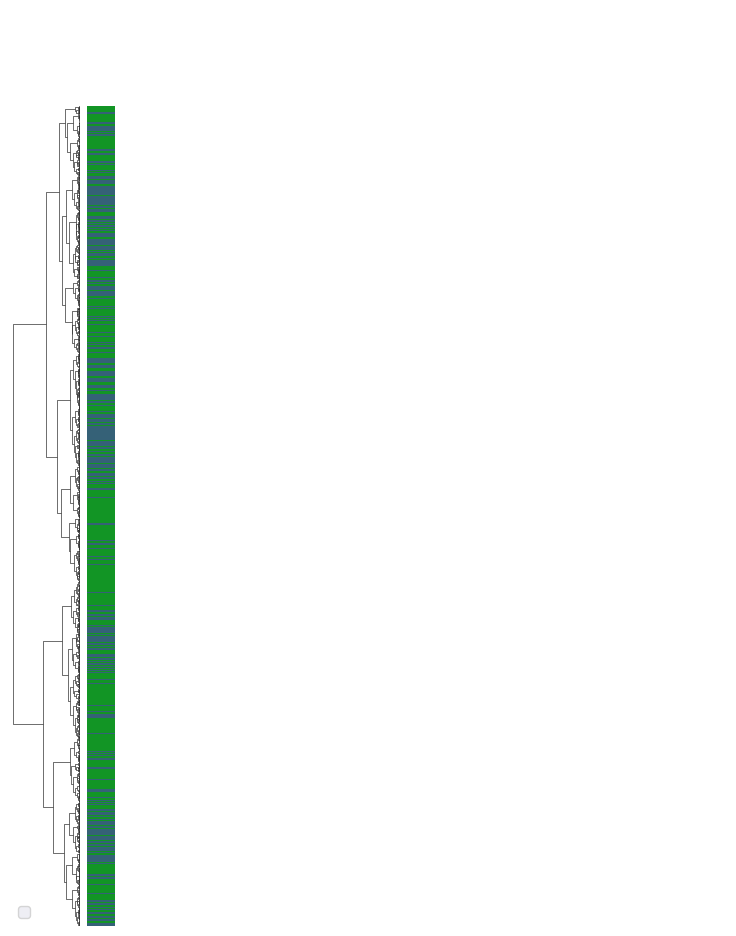

In [ ]:
plot_bar_dendrogram(df, 'exb_canon', 'embedding', 8, 10)

In [314]:
# write new df with canon info to disk
df.to_pickle(os.path.join(data_path, 'paintings_canonized.pkl'))

In [315]:
# save metadata dicts
with open(os.path.join(data_path, 'metadata_paintings'), "w") as json_file:
    json.dump(metadata, json_file, indent=2)